## Predicting Stock Market using Sentiment of Financial News with BERT

In this notebook, I will be using the sentiment analysis scores of the financial news. I have used the financial news articles from 2014-2017 as collected from Pulse, data bank managed by Zerodha. I will be trying to predict the Stock market movement using the sentiment analysis scores of the financial news. In this note book I will be using the BERT language model to get the sentiment scores of the news articles, which I will b eusing as the feture vectors to predict the directionility of the stock market movement. 

### Section 1) Importing Data and Library

In [1]:
#Importing pandas and numpy to manipulate datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

#Importing nltk library
import nltk
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from bs4 import BeautifulSoup

#Importing the librairies from transformers libarry
#!pip install transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
#Importing torch
import torch
#Importing requests to scrape the website
#import requests
#Importing beautiful soup to scrape the website
#from bs4 import BeautifulSoup
#import re

#Sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

#BERT

#Importing the AutoTokenizer module from the pre-trained BERT model
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

#Instantiating the model from the AutoModelForSequenceClassificationmodule of the pre-trained BERT Model
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mit_b\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
#Final Dataset being used will be named data_frame.csv, for purposes of the project
df = pd.read_csv("data_frame.csv")
#Cleaning the Data
df = df.drop(columns=['Unnamed: 0'])
df.head()

,Date,Combined_Headlines,Open,High,Low,Close
0,30-06-2017,Border crisis: Army chief Rawat in Sikkim as C...,30824.97,30965.45,30680.66,30921.61
1,29-06-2017,"Sensex pushes higher, Nifty reclaims 9550, ahe...",30910.97,31097.92,30794.61,30857.52
2,28-06-2017,"Nifty ends below 9,500; Reliance Industries dr...",30988.87,31000.48,30798.70,30834.32
3,27-06-2017,"Sensex tanks 180 points, Nifty50 holds 9,500; ...",31194.68,31294.96,30847.08,30958.25
4,23-06-2017,Piramal Enterprises board gives nod to raise u...,31352.57,31365.39,31110.39,31138.21


### Section 2) Data Pre-processing

In [3]:
#I am processing the Combined Headlines and cleaning the text. 
#I will be placing the cleaned text in the column, Processed_Headlines

#Ignoring the Warning for this cell. 
warnings.filterwarnings('ignore')

#Defining function to pre-process the text of the News Headlines
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

#Removing the HTML tags and URLs from the data
df['Combined_Headlines']=df['Combined_Headlines'].apply(lambda x: BeautifulSoup(x).get_text())
df['Combined_Headlines']=df['Combined_Headlines'].apply(lambda x: re.sub(r"http\S+", "", x))
#Removing extra spaces from the text
df['Combined_Headlines']=df['Combined_Headlines'].apply(lambda x: re.sub(' +', ' ', x))

#Storing the processed text in 'Processed_Headlines' column. 
df['Processed_Headlines'] = df['Combined_Headlines'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

df['Processed_Headlines']=df['Processed_Headlines'].apply(lambda x: " ".join([x for x in x.split() if x not in stop_words]))

#Lemmatization of the text
df['Processed_Headlines']=df['Processed_Headlines'].apply(lambda x:" ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))

df.head()

,Date,Combined_Headlines,Open,High,Low,Close,Processed_Headlines
0,30-06-2017,Border crisis: Army chief Rawat in Sikkim as C...,30824.97,30965.45,30680.66,30921.61,border crisis : army chief rawat sikkim china ...
1,29-06-2017,"Sensex pushes higher, Nifty reclaims 9550, ahe...",30910.97,31097.92,30794.61,30857.52,"sensex push higher , nifty reclaims 9550 , ahe..."
2,28-06-2017,"Nifty ends below 9,500; Reliance Industries dr...",30988.87,31000.48,30798.70,30834.32,"nifty end 9,500 ; reliance industry drag peopl..."
3,27-06-2017,"Sensex tanks 180 points, Nifty50 holds 9,500; ...",31194.68,31294.96,30847.08,30958.25,"sensex tank 180 point , nifty50 hold 9,500 ; b..."
4,23-06-2017,Piramal Enterprises board gives nod to raise u...,31352.57,31365.39,31110.39,31138.21,piramal enterprise board give nod raise r 125 ...


In [4]:
#Calculating the Daily Percentage change in the Close price of the Index
#I will be creating the label of 1/0 to be predicted later
df['Daily_Percentage_Change'] = df['Close'].pct_change()*100
df['Label'] = df['Daily_Percentage_Change'].apply(lambda x: 0 if x < 1 else 1)
df.head()

,Date,Combined_Headlines,Open,High,Low,Close,Processed_Headlines,Daily_Percentage_Change,Label
0,30-06-2017,Border crisis: Army chief Rawat in Sikkim as C...,30824.97,30965.45,30680.66,30921.61,border crisis : army chief rawat sikkim china ...,NaN,1
1,29-06-2017,"Sensex pushes higher, Nifty reclaims 9550, ahe...",30910.97,31097.92,30794.61,30857.52,"sensex push higher , nifty reclaims 9550 , ahe...",-0.207266,0
2,28-06-2017,"Nifty ends below 9,500; Reliance Industries dr...",30988.87,31000.48,30798.70,30834.32,"nifty end 9,500 ; reliance industry drag peopl...",-0.075184,0
3,27-06-2017,"Sensex tanks 180 points, Nifty50 holds 9,500; ...",31194.68,31294.96,30847.08,30958.25,"sensex tank 180 point , nifty50 hold 9,500 ; b...",0.401922,0
4,23-06-2017,Piramal Enterprises board gives nod to raise u...,31352.57,31365.39,31110.39,31138.21,piramal enterprise board give nod raise r 125 ...,0.581299,0


In [5]:
#I will be dropping the na values from the dataframe
df = df.dropna()
df.head()

,Date,Combined_Headlines,Open,High,Low,Close,Processed_Headlines,Daily_Percentage_Change,Label
1,29-06-2017,"Sensex pushes higher, Nifty reclaims 9550, ahe...",30910.97,31097.92,30794.61,30857.52,"sensex push higher , nifty reclaims 9550 , ahe...",-0.207266,0
2,28-06-2017,"Nifty ends below 9,500; Reliance Industries dr...",30988.87,31000.48,30798.70,30834.32,"nifty end 9,500 ; reliance industry drag peopl...",-0.075184,0
3,27-06-2017,"Sensex tanks 180 points, Nifty50 holds 9,500; ...",31194.68,31294.96,30847.08,30958.25,"sensex tank 180 point , nifty50 hold 9,500 ; b...",0.401922,0
4,23-06-2017,Piramal Enterprises board gives nod to raise u...,31352.57,31365.39,31110.39,31138.21,piramal enterprise board give nod raise r 125 ...,0.581299,0
5,22-06-2017,Exclusive: Fake online stores reveal gamblers'...,31351.53,31522.87,31255.63,31290.74,exclusive : fake online store reveal gambler '...,0.489848,0


In [6]:
#I will be dropping the columns not required hereafter
df = df.drop(columns=['Combined_Headlines','Open','High','Low','Close','Daily_Percentage_Change'])
df.head()

,Date,Processed_Headlines,Label
1,29-06-2017,"sensex push higher , nifty reclaims 9550 , ahe...",0
2,28-06-2017,"nifty end 9,500 ; reliance industry drag peopl...",0
3,27-06-2017,"sensex tank 180 point , nifty50 hold 9,500 ; b...",0
4,23-06-2017,piramal enterprise board give nod raise r 125 ...,0
5,22-06-2017,exclusive : fake online store reveal gambler '...,0


### Section 3) Sentiment Analysis

In [7]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

def sentiment_score_pos(sent):
    tokens = tokenizer.encode(sent, return_tensors='pt')
    result = model(tokens)
    prediction = torch.nn.functional.softmax(result.logits, dim=-1)
    pos = prediction[:, 0].tolist()[0]
    return pos

def sentiment_score_neg(sent):
    tokens = tokenizer.encode(sent, return_tensors='pt')
    result = model(tokens)
    prediction = torch.nn.functional.softmax(result.logits, dim=-1)
    neg = prediction[:, 1].tolist()[0]
    return neg

def sentiment_score_neut(sent):
    tokens = tokenizer.encode(sent, return_tensors='pt')
    result = model(tokens)
    prediction = torch.nn.functional.softmax(result.logits, dim=-1)
    neutr = prediction[:, 2].tolist()[0]
    return neutr

In [8]:
df['BERT_score']= df['Processed_Headlines'].apply(lambda x: sentiment_score(x[:512]))
df['BERT_pos']= df['Processed_Headlines'].apply(lambda x: sentiment_score_pos(x[:512]))
df['BERT_neg']= df['Processed_Headlines'].apply(lambda x: sentiment_score_neg(x[:512]))
df['BERT_neutr']= df['Processed_Headlines'].apply(lambda x: sentiment_score_neut(x[:512]))
df.head()

,Date,Processed_Headlines,Label,BERT_score,BERT_pos,BERT_neg,BERT_neutr
1,29-06-2017,"sensex push higher , nifty reclaims 9550 , ahe...",0,1,0.516302,0.254041,0.122045
2,28-06-2017,"nifty end 9,500 ; reliance industry drag peopl...",0,1,0.592651,0.235079,0.099565
3,27-06-2017,"sensex tank 180 point , nifty50 hold 9,500 ; b...",0,1,0.482937,0.310596,0.120765
4,23-06-2017,piramal enterprise board give nod raise r 125 ...,0,1,0.802986,0.149463,0.035932
5,22-06-2017,exclusive : fake online store reveal gambler '...,0,1,0.663777,0.204110,0.073955


In [9]:
y = df['Label']
y

1      0
2      0
3      0
4      0
5      0
      ..
777    0
778    0
779    0
780    0
781    0
Name: Label, Length: 781, dtype: int64

In [10]:
X = df[['BERT_score','BERT_pos','BERT_neg','BERT_neutr']]
X

,BERT_score,BERT_pos,BERT_neg,BERT_neutr
1,1,0.516302,0.254041,0.122045
2,1,0.592651,0.235079,0.099565
3,1,0.482937,0.310596,0.120765
4,1,0.802986,0.149463,0.035932
5,1,0.663777,0.204110,0.073955
...,...,...,...,...
777,1,0.272352,0.180845,0.195814
778,1,0.542867,0.218562,0.127617
779,5,0.015004,0.016946,0.045558
780,1,0.288835,0.113718,0.124222


## Unbalanced Dataset

In [12]:
#Splitting the dataset into train and test sets
X_train,X_test,y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=30)
print("Train: ",X_train.shape,y_train.shape,"Test: ",(X_test.shape,y_test.shape))

Train:  (624, 4) (624,) Test:  ((157, 4), (157,))


## Decision  Tree

In [13]:
#Decision tree 

from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0).fit(X_train,y_train)
dt_pred = dt.predict(X_test)

print('ROCAUC score:',roc_auc_score(y_test, dt_pred))
print('Accuracy score:',accuracy_score(y_test, dt_pred))
print('F1 score:',f1_score(y_test, dt_pred))

ROCAUC score: 0.52025
Accuracy score: 0.643312101910828
F1 score: 0.2631578947368421


## Gradient Boosting

In [14]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)

gb_pred = gb.predict(X_test)

print('ROCAUC score:',roc_auc_score(y_test, gb_pred))
print('Accuracy score:',accuracy_score(y_test, gb_pred))
print('F1 score:',f1_score(y_test, gb_pred))

ROCAUC score: 0.499625
Accuracy score: 0.7770700636942676
F1 score: 0.05405405405405406


## SVM

In [15]:
# load library
from sklearn.svm import SVC

# we can add class_weight='balanced' to add panalize mistake
svc_model = SVC(class_weight='balanced', probability=True)

svc_model.fit(X_train, y_train)

svc_predict = svc_model.predict(X_test)# check performance
print('ROCAUC score:',roc_auc_score(y_test, svc_predict))
print('Accuracy score:',accuracy_score(y_test, svc_predict))
print('F1 score:',f1_score(y_test, svc_predict))

ROCAUC score: 0.54225
Accuracy score: 0.3821656050955414
F1 score: 0.34899328859060397


## Balanced Dataset


In [16]:
#Balancing the Dataset
# example of random oversampling to balance the class distribution
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

#X = X.values.reshape(-1)
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
#X_over, y_over = oversample.fit_resample(X, y)
X_over, y_over = oversample.fit_resample(X,y)
# summarize class distribution
print(Counter(y_over))

#Splitting the dataset into train and test sets
X_train,X_test,y_train, y_test = train_test_split(X_over,y_over, test_size=0.20, random_state=30)
print("Train: ",X_train.shape,y_train.shape,"Test: ",(X_test.shape,y_test.shape))

Counter({0: 619, 1: 619})
Train:  (990, 4) (990,) Test:  ((248, 4), (248,))


## Decision Tree

In [17]:
#Decision tree 

from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0).fit(X_train,y_train)
dt_pred = dt.predict(X_test)

print('ROCAUC score:',roc_auc_score(y_test, dt_pred))
print('Accuracy score:',accuracy_score(y_test, dt_pred))
print('F1 score:',f1_score(y_test, dt_pred))

ROCAUC score: 0.8698174706649283
Accuracy score: 0.875
F1 score: 0.8912280701754386


## Gradient Boosting

In [18]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)

gb_pred = gb.predict(X_test)

print('ROCAUC score:',roc_auc_score(y_test, gb_pred))
print('Accuracy score:',accuracy_score(y_test, gb_pred))
print('F1 score:',f1_score(y_test, gb_pred))

ROCAUC score: 0.6700782268578879
Accuracy score: 0.6733870967741935
F1 score: 0.7032967032967035


## SVM

In [19]:
# load library
from sklearn.svm import SVC

# we can add class_weight='balanced' to add panalize mistake
svc_model = SVC(class_weight='balanced', probability=True)

svc_model.fit(X_train, y_train)

svc_predict = svc_model.predict(X_test)# check performance
print('ROCAUC score:',roc_auc_score(y_test, svc_predict))
print('Accuracy score:',accuracy_score(y_test, svc_predict))
print('F1 score:',f1_score(y_test, svc_predict))

ROCAUC score: 0.494393741851369
Accuracy score: 0.5080645161290323
F1 score: 0.6234567901234569


The best performance from all the above cells is clear that is the Decision Tree Classifier on a balanced dataset. Thus, I will be printing the accuracy scores of the same and plotting the confusion matrix of the Decision Tree Classifier performance. 

Accuracy of the Random Forest Classifier approach on NLTK Scores: 0.875


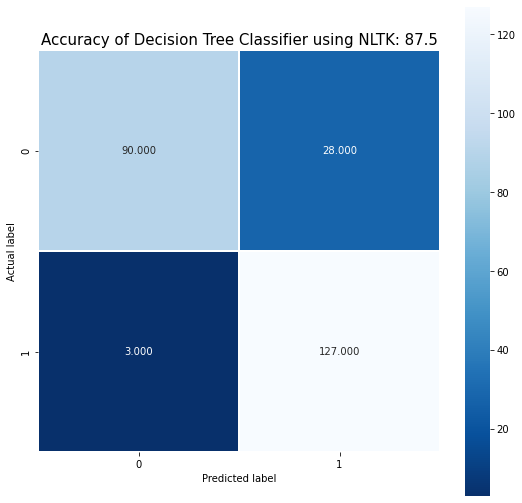

In [21]:
#Calculating the Confucion Matrix and Accuracy Scores
cm_DT = confusion_matrix(y_test, dt_pred)
Accuracy_Score_DT = accuracy_score(y_test, dt_pred)
print('Accuracy of the Random Forest Classifier approach on NLTK Scores:',round(Accuracy_Score_DT,4))

#Plotting the Confusion Matrix of the Predictions
plt.figure(figsize=(9,9))
sns.heatmap(cm_DT, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy of Decision Tree Classifier using NLTK: {0}'.format(round((Accuracy_Score_DT*100),4))
plt.title(all_sample_title, size = 15);